# Filter Zero Outter Analysis

In [1]:

import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from experiments.grid_size.experiment import GridSizeExperiment
from commands.datastore import Datastore
from functools import reduce
from parse import parse
import matplotlib.ticker as ticker

sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True
})

data_store = Datastore().derive("single_filter_zero_outter")
figures = data_store / "figures"
figures.mkdir(exist_ok=True, parents=True)
solutions_df = None

In [2]:
import os
from pathlib import Path


def create_df(path: str = data_store, tar_files = ["single_filter_zero_outter.tar"], best_solution=False) -> pd.DataFrame:
    path = Path(path)
    experiment_runs = set()
    for file in [path / tar for tar in tar_files]:
        with tarfile.open(file, "r:*") as tar:
            for f in tar.getnames():
                result = parse("{layer_name}_{i}_{j}/train_statistics/fitness/{file}", f)
                result = result or parse("{layer_name}_{i}_{j}_zero/train_statistics/fitness/{file}", f)
                if result is not None:
                    experiment = "{layer_name}_{i}_{j}".format(**result.named)
                    csv = pd.read_csv(tar.extractfile(f))
                    csv["Experiment"] = experiment
                    csv["zero"] = "Zero" if "zero" in f else "No Zero"
                    csv["error"] = csv["error"] / 16
                    occurence_string = experiment + "/" + result["file"]
                    
                    if occurence_string in experiment_runs:
                        csv["run"] = csv["run"] + 30
                    
                    experiment_runs.add(occurence_string)
                    
                    if best_solution:
                        yield csv.tail(n=1)
                    else:
                        yield csv
                else:
                    print(f"ignoring {f}")

def load_dfs(path: str = data_store, tar_files = ["single_filter_zero_outter.tar"], best_solution=False):
    df = pd.concat([df for df in create_df(path, tar_files, best_solution=best_solution)], ignore_index=True)
    df.drop(columns="depth", inplace=True, errors="ignore")
    df.drop_duplicates(subset=["generation"], inplace=True)
    df.columns = df.columns.str.title().str.replace("_", " ")
    return df

def get_best_solutions(df):
    best_solutions = []
    chromosomes_df: pd.DataFrame = df.dropna().sort_values(by=["Error", "Energy", "Delay", "Gate Count"], ascending=True)
    
    groups = chromosomes_df.groupby(by=["Experiment", "Run"])
    best_solutions = groups.apply(pd.DataFrame.head, n=1)
    return best_solutions  

fitness_columns = ["Error", "Energy", "Area", "Delay", "Gate Count"]
quantized_columns = ["Error", "Quantized Energy", "Quantized Delay"]

In [3]:
df = load_dfs()
df

ignoring conv1_1_0
ignoring conv1_1_0/cgp_configs
ignoring conv1_1_0/cgp_configs/cgp.1.config
ignoring conv1_1_0/cgp_configs/cgp.10.config
ignoring conv1_1_0/cgp_configs/cgp.11.config
ignoring conv1_1_0/cgp_configs/cgp.12.config
ignoring conv1_1_0/cgp_configs/cgp.13.config
ignoring conv1_1_0/cgp_configs/cgp.14.config
ignoring conv1_1_0/cgp_configs/cgp.15.config
ignoring conv1_1_0/cgp_configs/cgp.16.config
ignoring conv1_1_0/cgp_configs/cgp.17.config
ignoring conv1_1_0/cgp_configs/cgp.18.config
ignoring conv1_1_0/cgp_configs/cgp.19.config
ignoring conv1_1_0/cgp_configs/cgp.2.config
ignoring conv1_1_0/cgp_configs/cgp.20.config
ignoring conv1_1_0/cgp_configs/cgp.21.config
ignoring conv1_1_0/cgp_configs/cgp.22.config
ignoring conv1_1_0/cgp_configs/cgp.23.config
ignoring conv1_1_0/cgp_configs/cgp.24.config
ignoring conv1_1_0/cgp_configs/cgp.25.config
ignoring conv1_1_0/cgp_configs/cgp.26.config
ignoring conv1_1_0/cgp_configs/cgp.27.config
ignoring conv1_1_0/cgp_configs/cgp.28.config
ignorin

,Run,Generation,Timestamp,Error,Quantized Energy,Energy,Area,Quantized Delay,Delay,Gate Count,Chromosome,Experiment,Zero
0,1,1,0.000097,1742.0000,99414662737553176,0.020418,119.671500,3.335576e+18,0.66,20,NaN,conv1_1_0,No Zero
1,1,2,0.001123,548.1875,750449310244855197,0.154132,449.589395,3.689349e+18,0.73,17,NaN,conv1_1_0,No Zero
2,1,3,0.001796,546.5000,750449310244855197,0.154132,449.589395,3.689349e+18,0.73,17,NaN,conv1_1_0,No Zero
3,1,4,0.002400,43.6250,26281500410374258,0.005398,143.605795,1.869944e+18,0.37,17,NaN,conv1_1_0,No Zero
4,1,5,0.003227,14.6250,26305372552848826,0.005403,154.868995,1.869944e+18,0.37,17,NaN,conv1_1_0,No Zero
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27286,8,425054,71.082513,0.0000,0,0.000000,0.000000,0.000000e+00,0.00,3,"{9,16,5,5,2,5,5}([9]2,2,18)([10]5,6,21)([11]4,...",conv2_9_0_zero,Zero
27314,9,691,0.111115,0.0000,0,0.000000,0.000000,0.000000e+00,0.00,7,"{9,16,5,5,2,5,5}([9]4,5,22)([10]1,5,19)([11]3,...",conv2_9_0_zero,Zero
27316,9,2175,0.350394,0.0000,0,0.000000,0.000000,0.000000e+00,0.00,5,"{9,16,5,5,2,5,5}([9]4,5,22)([10]1,5,13)([11]3,...",conv2_9_0_zero,Zero
27317,9,178924,29.252200,0.0000,0,0.000000,0.000000,0.000000e+00,0.00,4,"{9,16,5,5,2,5,5}([9]4,4,22)([10]1,5,13)([11]3,...",conv2_9_0_zero,Zero


### Evolution Statistics

ignoring conv1_1_0
ignoring conv1_1_0/cgp_configs
ignoring conv1_1_0/cgp_configs/cgp.1.config
ignoring conv1_1_0/cgp_configs/cgp.10.config
ignoring conv1_1_0/cgp_configs/cgp.11.config
ignoring conv1_1_0/cgp_configs/cgp.12.config
ignoring conv1_1_0/cgp_configs/cgp.13.config
ignoring conv1_1_0/cgp_configs/cgp.14.config
ignoring conv1_1_0/cgp_configs/cgp.15.config
ignoring conv1_1_0/cgp_configs/cgp.16.config
ignoring conv1_1_0/cgp_configs/cgp.17.config
ignoring conv1_1_0/cgp_configs/cgp.18.config
ignoring conv1_1_0/cgp_configs/cgp.19.config
ignoring conv1_1_0/cgp_configs/cgp.2.config
ignoring conv1_1_0/cgp_configs/cgp.20.config
ignoring conv1_1_0/cgp_configs/cgp.21.config
ignoring conv1_1_0/cgp_configs/cgp.22.config
ignoring conv1_1_0/cgp_configs/cgp.23.config
ignoring conv1_1_0/cgp_configs/cgp.24.config
ignoring conv1_1_0/cgp_configs/cgp.25.config
ignoring conv1_1_0/cgp_configs/cgp.26.config
ignoring conv1_1_0/cgp_configs/cgp.27.config
ignoring conv1_1_0/cgp_configs/cgp.28.config
ignorin

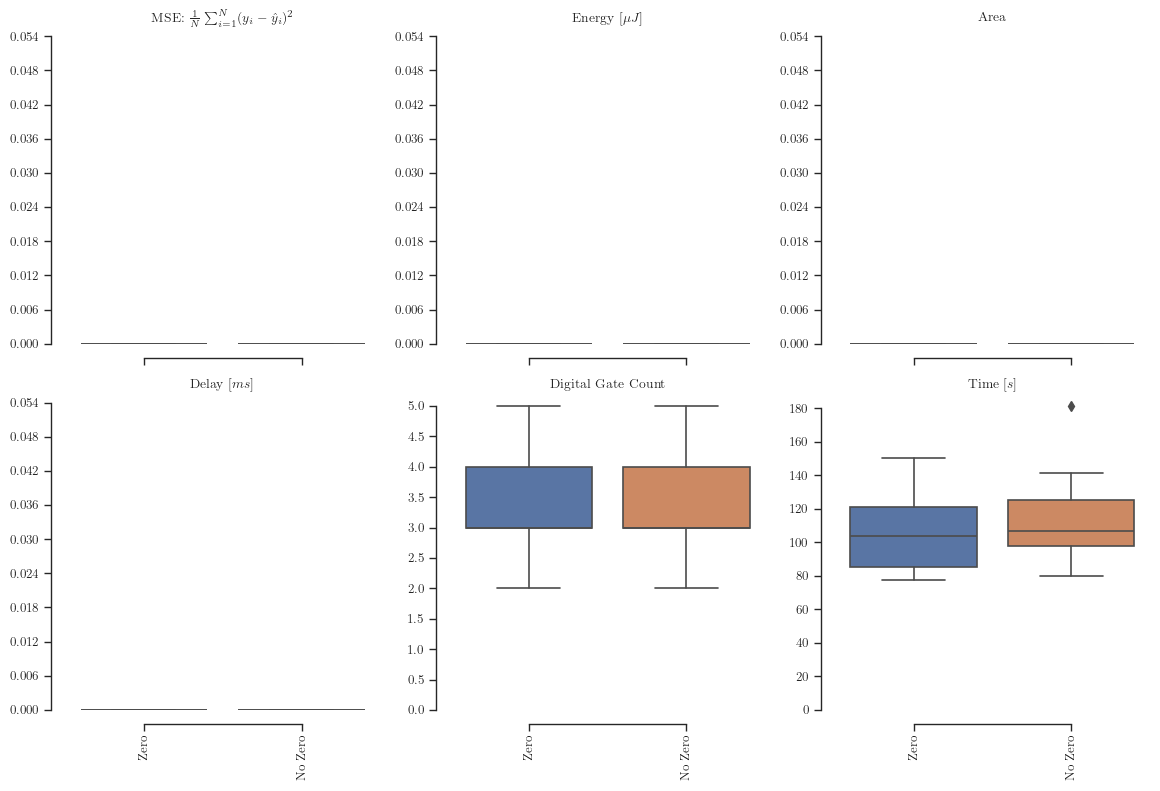

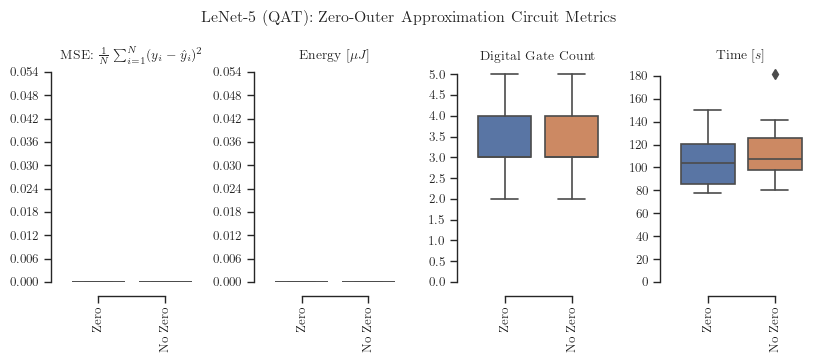

In [4]:
order=["Zero", "No Zero"]
def load_df(tar_files = ["single_filter_zero_outter.tar"]):
    solutions_df = load_dfs(tar_files=tar_files, best_solution=True)
    return solutions_df

titles = {
    "Error": r"MSE: $\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$",
    "Energy": "Energy [$\mu J$]",
    "Area": "Area",
    "Delay": "Delay [$ms$]",
    "Gate Count": "Digital Gate Count",
    "Generation": "Generations",
    "Timestamp": "Time $[s]$"
}

def plot(solutions_df, col, ax, i, sharex_index=True, landscape=False):
    tick_count = (solutions_df["Gate Count"].max() + 1) // (2 if (col != "Gate Count") else 1)
    if col == "Timestamp":
        solutions_df = solutions_df.groupby(by=["Zero", "Run"])["Timestamp"].max().reset_index()        
    g = sns.boxplot(data=solutions_df, x="Zero", y=col, order=order, ax=ax)
    g.yaxis.set_major_locator(plt.MaxNLocator(tick_count, min_n_ticks=10, integer=(col=="Gate Count")))
    g.set_ylim(0)
    g.set_title(titles[col])
    g.set_ylabel(None)
    g.set_xlabel(None)
    g.tick_params(axis="x", rotation=90)
    if i < sharex_index:
        g.axes.get_xaxis().set_ticklabels([])
        g.set_xlabel(None)
    return g    

def plot_columns(df, columns, r, c, sharex=True, landscape=False):
    fig, axes = plt.subplots(r, c, figsize=(8.27 if not landscape else 11.69, 3.65 * r if not landscape else 8))
    for col, ax, i in zip(columns, axes.flat, range(r*c)):
        plot(df, col, ax, i, c if sharex else 0, landscape=landscape)    
    return fig

solutions_df = solutions_df if solutions_df is not None else load_df()
fig_all = plot_columns(solutions_df, fitness_columns + ["Timestamp"], 2, 3, landscape=True)
sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_all)
fig_all.tight_layout()
fig_all.savefig(figures / "boxplot.png")
fig_all.savefig(figures / "boxplot.pdf")
fig_all.savefig(figures / "boxplot.svg")

fig_brief = plot_columns(solutions_df, ["Error", "Energy", "Gate Count", "Timestamp"], 1, 4, sharex=False)
fig_brief.suptitle("LeNet-5 (QAT): Zero-Outer Approximation Circuit Metrics")
sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_brief)
fig_brief.tight_layout()
fig_brief.savefig(figures / "boxplot_brief.png")
fig_brief.savefig(figures / "boxplot_brief.pdf")
fig_brief.savefig(figures / "boxplot_brief.svg")

### Hypothesis Testing

In [5]:
import scipy.stats as stats
import scikit_posthocs as sp

solutions_df = solutions_df if solutions_df is not None else load_df()

def examine(df, grid1, grid2, variable, alternative="less"):
    group1 = df.loc[df["Zero"] == grid1, variable]
    group2 = df.loc[df["Zero"] == grid2, variable]
    levene_stat, levene_p = stats.levene(group1, group2)
    normal_a_stat = stats.normaltest(group1)
    normal_b_stat = stats.normaltest(group2)
    if normal_a_stat.pvalue >= 0.05 and normal_b_stat.pvalue >= 0.05:
        result = stats.ttest_ind(group1, group2, equal_var=levene_p>=0.5, alternative=alternative)
        test = "T-Test"
    else:
        result = stats.mannwhitneyu(group1, group2, alternative=alternative)
        test = "MWU"    
    print(f"Result: {'HA' if result.pvalue < 0.05 else 'H0'} , Hypotheses: H0: {variable}[{grid1}] == {variable}[{grid2}]; HA: {variable}[{grid1}] < {variable}[{grid2}], samples = {len(group1.index)}: {test}, {result}")
    

order=["2,2", "3,3", "5,5", "10,10"]
# anova = stats.kruskal(*groups)
# print(stats.kruskal(*groups))

# if anova.pvalue < 0.5:
#     print(sp.posthoc_dunn(solutions_df, group_col="Grid", val_col=variable).to_latex())

time_df = solutions_df.groupby(by=["Zero", "Run"])["Timestamp"].max().reset_index()
examine(solutions_df, "Zero", "No Zero", "Energy")
examine(time_df, "Zero", "No Zero", "Timestamp")
examine(solutions_df, "Zero", "No Zero", "Gate Count")

t1_mean = time_df.loc[time_df["Zero"] == "Zero", "Timestamp"].mean()
t2_mean = time_df.loc[time_df["Zero"] == "No Zero", "Timestamp"].mean()
print(t2_mean / t1_mean)

print(df.loc[df["Zero"] == "Zero", "Gate Count"].describe())
print(df.loc[df["Zero"] == "No Zero", "Gate Count"].describe())

Result: H0 , Hypotheses: H0: Energy[Zero] == Energy[No Zero]; HA: Energy[Zero] < Energy[No Zero], samples = 415: MWU, MannwhitneyuResult(statistic=87150.0, pvalue=1.0)
Result: H0 , Hypotheses: H0: Timestamp[Zero] == Timestamp[No Zero]; HA: Timestamp[Zero] < Timestamp[No Zero], samples = 30: MWU, MannwhitneyuResult(statistic=361.0, pvalue=0.09536516673578388)
Result: HA , Hypotheses: H0: Gate Count[Zero] == Gate Count[No Zero]; HA: Gate Count[Zero] < Gate Count[No Zero], samples = 415: T-Test, TtestResult(statistic=-2.229177298622507, pvalue=0.013034360209290507, df=831.0362577142183)
1.0693454823760125
count    1374.000000
mean        3.989083
std         1.150330
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        10.000000
Name: Gate Count, dtype: float64
count    1713.000000
mean        4.832458
std         2.434530
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        21.000000
Name: Gate Count, dty

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\scipy\stats\_morestats.py:3189: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
